In [1]:
import solveBSE_fromG4_threeband5new

self.symmetrize_G4= False
Transferred frequency iwm =  0
Transferred momentum q =  [0. 0.]
Vertex channel =  PARTICLE_PARTICLE_UP_DOWN
Inverse temperature =  16.0
U_pp =  0.0
U_dd =  8.5
t_pp =  0.49
t_pd =  1.13
ep_p =  3.24
ep_d =  4.25
filling =  0.95
actual filling: [0.94997841]
sign: [0.86296]
orbital occupancy: [[0.31331869 0.08082043 0.08085009]
 [0.31331869 0.08082043 0.08085009]]
Cu filling = 0.6266373762114684
Ox filling = 0.1616408522828232
Oy filling = 0.16170018261299643
L2_Sigma_difference = [0.00525359]
Imsimga= [ 0.68119313 -0.68119313 -0.87402179 -0.91574459 -0.92262857 -0.92063926
 -0.91815462 -0.91788935 -0.92028604 -0.92336345 -0.92931974]
K-vectors:  [[0.         0.        ]
 [0.         3.14159265]
 [3.14159265 0.        ]
 [3.14159265 3.14159265]]
NwG4:  32
NtG:  258
NwG :  256
Nc  :  4
nOrb:  3
G4shape0 =  32 , G4shape1 =  4 , G4shape2 =  32 , G4shape3 =  4 , G4shape4 =  3 , G4shape5 =  3 , G4shape6 =  3 , G4shape7 =  3
Index of transferred momentum:  0
G4 s-wav

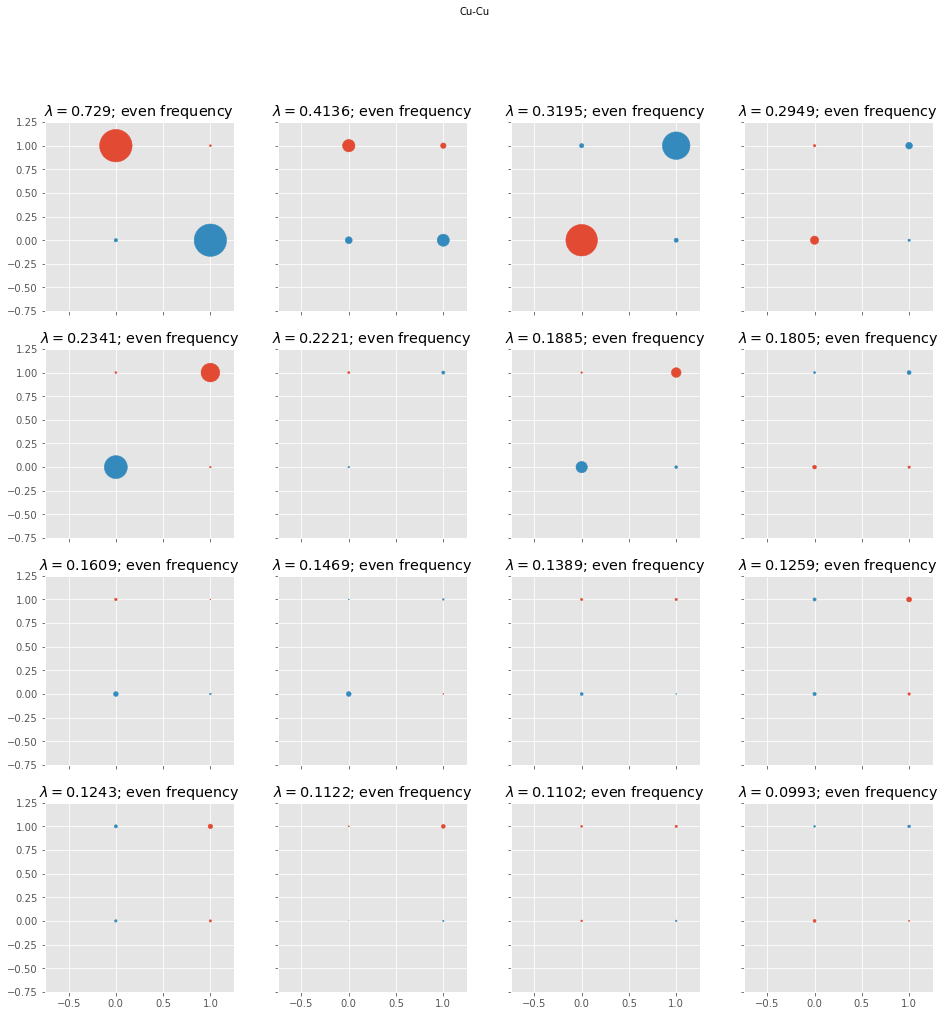

In [2]:
b=solveBSE_fromG4_threeband5new.BSE("./d0.95/T=0.0625/dca_tp_gpu.hdf5",fileG="dca_sp.hdf5",\
                                    draw=True,useG0=False,\
                                    symmetrize_G4=False,phSymmetry=False,calcRedVertex=False,\
                                    calcCluster=False,nkfine=100)

In [3]:
'''
Follow the procedure in Eq.(13) of PRB 103, 144514 (2021) by Peizhi Mai
'''
import numpy as np
import math
from numpy import *
import matplotlib.pyplot as mpl
import h5py
import sys
import os
from matplotlib.pyplot import *
import matplotlib as mpll

nt = b.nt; nc=b.Nc; nw=b.NwG4; nOrb=b.nOrb;
Kvecsnonneg=b.Kvecs.copy()

# switch all K points to be positive within (0,2*pi)
for i in range(b.Nc):
    if (b.Kvecs[i,0]<0):
        Kvecsnonneg[i,0] = Kvecsnonneg[i,0] +2*np.pi
    if (b.Kvecs[i,1]<0):
        Kvecsnonneg[i,1] = Kvecsnonneg[i,1] +2*np.pi
        
rightmatrix = zeros((nc,nOrb,nOrb),dtype='complex')
leftmatrix = zeros((nc,nOrb,nOrb),dtype='complex')

leftmatrix[:,0,0]=rightmatrix[:,0,0]=1.0

# Eq.(2-3) of PRB
for k in range(b.Nc):
    gammak = sqrt(sin(b.Kvecs[k,0]/2)**2+sin(b.Kvecs[k,1]/2)**2)
    if (abs(gammak) < 1.e-10):
        rightmatrix[k,1,1]= 1j/sqrt(2)
        rightmatrix[k,1,2]= -1j/sqrt(2)
        rightmatrix[k,2,1]= -1j/sqrt(2)
        rightmatrix[k,2,2]= -1j/sqrt(2)
        leftmatrix[k,1,1]= -1j/sqrt(2)
        leftmatrix[k,1,2]= 1j/sqrt(2)
        leftmatrix[k,2,1]= 1j/sqrt(2)
        leftmatrix[k,2,2]= 1j/sqrt(2)
    else:
        kx = b.Kvecs[k,0]; ky = b.Kvecs[k,1];
        if (kx < 0):
            kx = kx +2*np.pi
        if (ky < 0):
            ky = ky +2*np.pi
        rightmatrix[k,1,1]= 1j * sin(kx/2)/gammak
        rightmatrix[k,1,2]= -1j * sin(ky/2)/gammak
        rightmatrix[k,2,1]= -1j * sin(ky/2)/gammak
        rightmatrix[k,2,2]= -1j * sin(kx/2)/gammak
        leftmatrix[k,1,1]= -1j * sin(kx/2)/gammak
        leftmatrix[k,1,2]= 1j * sin(ky/2)/gammak
        leftmatrix[k,2,1]= 1j * sin(ky/2)/gammak
        leftmatrix[k,2,2]= 1j * sin(kx/2)/gammak
                            
def changeG4LLbar(Tchi0LLbar,Tchi0):
    Tchi0LLbartemp1 = zeros((b.NwG4,b.Nc,b.nOrb,b.nOrb,b.NwG4,b.Nc,b.nOrb,b.nOrb),dtype='complex')
    for l2 in range(nOrb):
        for l1 in range(nOrb):
            for k1 in range(b.Nc):
                for k2 in range(b.Nc):
                    for iw1 in range(b.NwG4):
                        for iw2 in range(b.NwG4):
                            Tchi0LLbartemp1[iw1,k1,:,:,iw2,k2,l1,l2]= \
                            np.dot(np.dot(leftmatrix[k1,:,:],Tchi0[iw1,k1,:,:,iw2,k2,l1,l2]),\
                                   rightmatrix[k1,:,:])

    for l4 in range(nOrb):
        for l3 in range(nOrb):
            for k1 in range(b.Nc):
                for k2 in range(b.Nc):
                    for iw1 in range(b.NwG4):
                        for iw2 in range(b.NwG4):
                            Tchi0LLbar[iw1,k1,l3,l4,iw2,k2,:,:]= \
                            np.dot(np.dot(rightmatrix[k2,:,:],Tchi0LLbartemp1[iw1,k1,l3,l4,iw2,k2,:,:]),\
                                   leftmatrix[k2,:,:])
        
gkd = cos(Kvecsnonneg[:,0]) - cos(Kvecsnonneg[:,1])
        
# lambdas2 is leading eigenvalues of pm2 matrix in solveBSE*.py
eigval = b.lambdas2
Lambda = np.diag(1./(1-eigval))
chi0 = b.chi0

# Dkk = zeros((nt,nt), dtype=real)
phit =zeros((nw,nc,nOrb,nOrb,nt), dtype=complex)
phit2=zeros((nw,nc,nOrb,nOrb,nt), dtype=complex)
Dkk =zeros((nw,nc,nOrb,nOrb,nw,nc,nOrb,nOrb), dtype=complex)
Dkk2=zeros((nw,nc,nOrb,nOrb,nw,nc,nOrb,nOrb), dtype=complex)
Pd =zeros((nOrb,nOrb,nOrb,nOrb), dtype=complex)
PdIa =zeros((nOrb,nOrb,nOrb,nOrb), dtype=complex)

# all eigenvectors
for ialpha in range(nt):
    phit[:,:,:,:,ialpha] = b.evecs2[:,:,:,:,ialpha]
    
# leading eigenvector specific for Eq.(14) of PRB
phit2[:,:,:,:,0] = b.evecs2[:,:,:,:,0]

#phi = phit.reshape(nt,nt)
#phi2 = phit2.reshape(nt,nt)

evecsM = b.evecs2.reshape(nt,nt)
Dkktemp = dot(phit,dot(Lambda,linalg.inv(evecsM)))
Dkktemp2 = Dkktemp.reshape(nt,nt)
Dkk = dot(b.chi0M,Dkktemp2)
#Dkk = dot(phi,dot(Lambda,phi.T))
Dkk = Dkk.reshape(nw,nc,nOrb,nOrb,nw,nc,nOrb,nOrb)
#Dkk2 = dot(phi2,dot(Lambda,phi2.T))
Lambda2 = Lambda.copy()
for i in range(len(Lambda)):
    Lambda2[i,i] = 0.0
Lambda2[0,0] = Lambda[0,0]
Dkk2temp = dot(phit2,dot(Lambda2,linalg.inv(evecsM)))
Dkk2temp2 = Dkk2temp.reshape(nt,nt)
Dkk2 = dot(b.chiMasqrt,dot(Dkk2temp2,b.chiMasqrt))
Dkk2 = Dkk2.reshape(nw,nc,nOrb,nOrb,nw,nc,nOrb,nOrb)
DkkLLbar = zeros((b.NwG4,b.Nc,b.nOrb,b.nOrb,b.NwG4,b.Nc,b.nOrb,b.nOrb),dtype='complex')
Dkk2LLbar = zeros((b.NwG4,b.Nc,b.nOrb,b.nOrb,b.NwG4,b.Nc,b.nOrb,b.nOrb),dtype='complex')
changeG4LLbar(DkkLLbar,Dkk)
changeG4LLbar(Dkk2LLbar,Dkk2)
LkkLLbar = sum(sum(DkkLLbar,axis=0),axis=3)
Lkk2LLbar = sum(sum(Dkk2LLbar,axis=0),axis=3)
for l1 in range(nOrb):
    for l2 in range(nOrb):
        for l3 in range(nOrb):
            for l4 in range(nOrb):
                Pd[l1,l2,l3,l4] = dot(gkd,dot(LkkLLbar[:,l1,l2,:,l3,l4],gkd)) * b.temp/b.Nc
                PdIa[l1,l2,l3,l4] = dot(gkd,dot(Lkk2LLbar[:,l1,l2,:,l3,l4],gkd)) * b.temp/b.Nc
                
Pd0 =zeros((nOrb,nOrb,nOrb,nOrb), dtype=complex)
Pd0Ia =zeros((nOrb,nOrb,nOrb,nOrb), dtype=complex)
for i in range(len(Lambda)):
    Lambda[i,i] = 1.0
for ialpha in range(nt):
    phit[:,:,:,:,ialpha] = b.evecs2[:,:,:,:,ialpha]
phit2[:,:,:,:,0] = b.evecs2[:,:,:,:,0]
        #phi = phit.reshape(nt,nt)
        #phi2 = phit2.reshape(nt,nt)
evecsM = b.evecs2.reshape(nt,nt)
Dkktemp = dot(phit,dot(Lambda,linalg.inv(evecsM)))
Dkktemp2 = Dkktemp.reshape(nt,nt)
Dkk = dot(b.chi0M,Dkktemp2)
#Dkk = dot(phi,dot(Lambda,phi.T))
Dkk = Dkk.reshape(nw,nc,nOrb,nOrb,nw,nc,nOrb,nOrb)
#Dkk2 = dot(phi2,dot(Lambda,phi2.T))
Dkk2temp = dot(phit2,linalg.inv(evecsM))
Dkk2temp2 = Dkk2temp.reshape(nt,nt)
Dkk2 = dot(b.chiMasqrt,dot(Dkk2temp2,b.chiMasqrt))
Dkk2 = Dkk2.reshape(nw,nc,nOrb,nOrb,nw,nc,nOrb,nOrb)
DkkLLbar = zeros((b.NwG4,b.Nc,b.nOrb,b.nOrb,b.NwG4,b.Nc,b.nOrb,b.nOrb),dtype='complex')
Dkk2LLbar = zeros((b.NwG4,b.Nc,b.nOrb,b.nOrb,b.NwG4,b.Nc,b.nOrb,b.nOrb),dtype='complex')
changeG4LLbar(DkkLLbar,Dkk)
changeG4LLbar(Dkk2LLbar,Dkk2)
LkkLLbar = sum(sum(DkkLLbar,axis=0),axis=3)
Lkk2LLbar = sum(sum(Dkk2LLbar,axis=0),axis=3)
for l1 in range(nOrb):
    for l2 in range(nOrb):
        for l3 in range(nOrb):
            for l4 in range(nOrb):
                Pd0[l1,l2,l3,l4] = dot(gkd,dot(LkkLLbar[:,l1,l2,:,l3,l4],gkd)) * b.temp/b.Nc
                Pd0Ia[l1,l2,l3,l4] = dot(gkd,dot(Lkk2LLbar[:,l1,l2,:,l3,l4],gkd)) * b.temp/b.Nc
print("Pd=",np.sum(Pd))
print("PdIa=",np.sum(PdIa))
print("Pd0=",np.sum(Pd0))
print("Pd0/(1-lambda)=",np.sum(Pd0)/(1-b.lambdas2[0].real))
print("Pd0Ia=",np.sum(Pd0Ia))
print("Pd0Ia/(1-lambda)=",np.sum(Pd0Ia)/(1-b.lambdas2[0].real))

Pd= (9.404704065074982+3.944814315672833e-15j)
PdIa= (6.5809122655135335-1.7783640099035203e-14j)
Pd0= (4.35917023692466+7.119516334199065e-15j)
Pd0/(1-lambda)= (16.087556297493276+2.6274637972880325e-14j)
Pd0Ia= (1.7831991602173303-3.990238254899947e-15j)
Pd0Ia/(1-lambda)= (6.5809122655135335-1.4726009556213546e-14j)
